












































































































































































































































































































































<h1><center><font color='24568A'>Pump it up</font></center></h1>
<h2><center><font color='24568A'>Group E</font></center></h2>


<html>
<img src="https://s3.amazonaws.com/drivendata/comp_images/pumping.jpg" width="90%">
</html>



# 1. Understanding the business

The Tanzanian Ministry of Water provides water to their people using water pumps they distributed over the country. To ensure that clean, potable water is available to communities at all time and to improve maintenance operations the ministry requires an understanding of which water pumps are likely to work, which pumps will work but will need maintenance and which are likely to fail. To predict which pumps are functional, need to be repaired or are defect, a multiclass classification model must be designed based on a selected group of variables. Historical data about the waterpoints was collected from the Taarifa dashboard, a platform for crowd sourced reporting and assigning degrees of urgency of infrastructure related issues.

For addressing this multiclass classification problem we were given a dataset with about 40 features, both numerical and categorical, which describe a pump. We have a very diverse set of information with this features, from which we can get the following information:

- Geographical data

- Demographic data

- Pump's characteristics (waterpoint, source, height, etc)

- Information from funder, installer and manager from the pumps

- Quality and quantity of the water that comes out of the pump


With this information we will analyze each one of the features, try to get more information from the existing data, clean the data and consolidate one unique dataset that can have only relevant information for building a machine learning model that can help solve this problem. We understand that more than a business problem, the solution that we provide has also social consequences, and we will consider this in our analysis for prioritizing the most relevant information that the Ministry of Water would need.

# 2. Understanding data
## 2.1 Data loading

In [1]:
import pandas as pd
#load and merge train set
trainX = pd.read_csv('trainX.csv', delimiter=',')
trainY = pd.read_csv('trainY.csv', delimiter= ',')
trainDF = trainX.merge(trainY)
trainDF['dataset'] = 'train'

#load test set 
testDF = pd.read_csv('testPump.csv', delimiter=',')
testDF['status_group'] = 'functional'
testDF['dataset'] = 'test'

#append train and set for feature engineering
trainTestDF = trainDF.append(testDF, sort= False)

#check for the distribution of the target variable in the train set

print('Percentage of functional pumps on the train set: ' + format((sum(trainY['status_group'] == 'functional')/len(trainY))*100))
print('Percentage of non functional pumps on the train set: ' + format((sum(trainY['status_group'] == 'non functional')/len(trainY))*100))
print('Percentage of functional need repair pumps on the train set: ' + format((sum(trainY['status_group'] == 'functional needs repair')/len(trainY))*100))


Percentage of functional pumps on the train set: 54.3080808080808
Percentage of non functional pumps on the train set: 38.42424242424242
Percentage of functional need repair pumps on the train set: 7.267676767676767


For this business case we have a clear classes imbalance, given that whereas functional and non functional pumps are similar in terms of proportion (54% and 38% respectively), the proportion of pumps that are functional but need repair is very low. This is something that we will consider in our analysis, because we don't want our classifier to be biased towards functional and non functional pumps only.


In [2]:
trainTestDF.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Describing the trainTestDF dataframe allows us to see that for most of the numerical values there are a lot of zeros in the feature values. This could be a normal value in some cases, but for most of them might mean that those are missing values, therefore we are going to address this issue in the data cleaning stage. 

## 2.2 Target variable encoding 
For simplifying the meaning of the values in the target variable, we will encode this values with numbers, so that the algorithms can process this information in a better way.

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = preprocessing.LabelEncoder()
le.fit(["non functional", "functional needs repair","functional"])

trainTestDF['status_group'] = le.transform(trainTestDF['status_group'])
trainTestDF['status_group'] = trainTestDF['status_group'].astype('int64')

## 2.3  Cleaning data
We will start cleaning the data in the numerical features, we will look for outliers and make the adjustments that are necessary for having a clean dataset. Afterwards we'll check the quality of the values in the categorical features and perform the cleaning process as well.

## Numerical variables

### 2.3.1 Null values
There are not null values in the numerical features, but as we mentioned before, there a lot of zeros in some features that seem to be incorrect values.

In [4]:
#checking for null values in the numerical features
numericalFeaturesList = ['amount_tsh','gps_height','longitude','latitude','population','construction_year']
print('Null values in numerical features:' + format(trainTestDF[numericalFeaturesList].isnull().sum().sum()))

Null values in numerical features:0


### 2.3.2 Fixing incorrect values (zeros)

In [5]:
import numpy as np
#read latitude and longitude as numbers
trainTestDF['latitude'] = np.where((trainTestDF['latitude']>-0.1)&(trainTestDF['latitude']<0.1),0,trainTestDF['latitude'])
trainTestDF['longitude'] = np.where((trainTestDF['longitude']>-0.1)&(trainTestDF['longitude']<0.1),0,trainTestDF['longitude'])


In [6]:
print('Zero values in amount_tsh: ' + format(sum(trainTestDF['amount_tsh']==0)))
print('Zero values in gps_height: ' + format(sum(trainTestDF['gps_height']==0)))
print('Zero values in latitude: ' + format(sum(trainTestDF['latitude']==0)))
print('Zero values in longitude: ' + format(sum(trainTestDF['longitude']==0)))
print('Zero values in population: ' + format(sum(trainTestDF['population']==0)))
print('Zero values in construction_year: ' + format(sum(trainTestDF['construction_year']==0)))


Zero values in amount_tsh: 52049
Zero values in gps_height: 25649
Zero values in latitude: 2269
Zero values in longitude: 2269
Zero values in population: 26834
Zero values in construction_year: 25969


**amount_tsh:** This feature has zeros in 70% of the observations in the merged train and test set. This feature shows the amount of water available to waterpoint, and for what we've learned in our research this is a value that could be true. Nevertheless, given that most of the data is zero, wether the zeros are right or wrong, we don't feel comfortable imputing a value considering the high proportion of zeros. We consider that this feature is not informative and thus we will not perform any cleaning on it.

**gps_height:** Given that this feature represents the altitude of the well we consider that this is a missing value.

**latitude and longitude:** Even if it is possible to have values equal to zero in the feature latitude (around the line that divides the Equator) and in the feature longitude (prime meridian), in this case it does not make sense. Considering that both latitude and longitude are zero in all cases with "missing data", these coordinates correspond to an island in the Atlantic Ocean that does not belong to Tanzania nor it is near this country.

**population:** Even if a pump can be located in a low populated area as we can see in some observations, we consider that zero is a missing value. Additionally, from the information we have we don't know which distance is being considered to measure the population around the pump, therefore we'll change this values as if they are incorrect.

**construction_year:** It is not possible that a pump was built in year zero, therefore those are missing values.

### Latitude and longitude
Given that these are geographical variables, we don't want to impute a general value for the observations that have zeros in latitude and longitude. We will use the feature *basin*, which refers to the geographical water basin, for trying to "deduce" the mean values of latitude and longitude that are within this basin.

In [7]:
#impute mean value by basin in missing values for latitude and longitude
#setting numerical columns as numeric
import seaborn as sns
numericalColumnsList = ['id','amount_tsh','gps_height','population','construction_year']

for col in numericalColumnsList:
    trainTestDF[col] = trainTestDF[col].astype('int64')
    
#1. replace zeros with nan

trainTestDF["latitude"].replace(0, np.nan, inplace=True)
trainTestDF["longitude"].replace(0, np.nan, inplace=True)
pd.set_option('display.max_columns', None)

#2. replace nan with mean of each basin for latitude and longitude

trainTestDF['latitude'] = trainTestDF['latitude'].fillna(trainTestDF.groupby('basin')['latitude'].transform('mean'))
trainTestDF['longitude'] = trainTestDF['longitude'].fillna(trainTestDF.groupby('basin')['longitude'].transform('mean'))
print('Zero values in latitude after imputing mean by basin: ' + format(sum(trainTestDF['latitude']==0)))
print('Zero values in longitude after imputing mean by basin: ' + format(sum(trainTestDF['longitude']==0)))

Zero values in latitude after imputing mean by basin: 0
Zero values in longitude after imputing mean by basin: 0


### Population
We will continue using the *basin* feature for imputing the median value of the population. We prefer to use *basin* instead of other geographical features available like *region, subregion, district_code*, among others, for two main reasons:

1. The basin feature contains a geographical component related to the amount of water available, which has more information than just the geographical location.

2. The missing values are present sometimes in subregions or districts that have only one record, therefore it is not possible to assign a value.

5214


basin
Internal                   200.0
Lake Nyasa                  63.0
Lake Rukwa                 250.0
Lake Tanganyika            350.0
Lake Victoria              320.0
Pangani                     98.0
Rufiji                     100.0
Ruvuma / Southern Coast    210.0
Wami / Ruvu                120.0
Name: population, dtype: float64

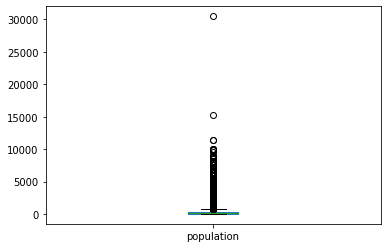

In [8]:
#1. replace zeros with nan and understand distribution
trainTestDF["population"].replace(0, np.nan, inplace=True)
trainTestDF['population'].plot(kind='box')
print(sum(trainTestDF['population']>550))
trainTestDF.groupby('basin')['population'].agg('median')

Before assigning values to the observations that have a value of zero in population, we will remove outliers first because we don't want to consider them in the population by basin.

From the boxplot and the grouped dataframe above it is possible to see that there are multiple outliers in the population feature. Therefore, we will replace every outlier with the value **q3 + 1.5 iqr**, because we don't want to lose the information from other features and we believe that we are still representing a high value of population with this change.

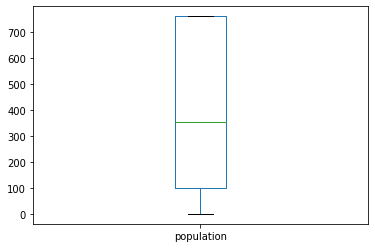

In [9]:
#2. remove outliers in population before imputing values
import warnings; warnings.simplefilter('ignore')
def change_outliers(dataframe,column):
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        highest = q3 + 1.5*iqr
        lowest = q1 - 1.5*iqr
        median = dataframe.loc[dataframe[column]<q3 + 1.5*iqr, column].median()
        mean = dataframe[column].mean()
        outliersUp = (dataframe[column]).abs() > round(q3 + 1.5*iqr)
        outliersDown = (dataframe[column]).abs() < round(q1 - 1.5*iqr)
        dataframe[column][outliersUp] = np.nan
        dataframe[column].fillna(highest, inplace=True)
        dataframe[column][outliersDown] = np.nan
        dataframe[column].fillna(lowest, inplace=True)
        
change_outliers(trainTestDF,'population')
trainTestDF['population'].plot(kind='box')

In [10]:
#3. impute median population by basin in nan values
trainTestDF['population'] = trainTestDF['population'].fillna(trainTestDF.groupby('basin')['population'].transform('median'))
print('Zero values in population: ' + format(sum(trainTestDF['population']==0)))
print('Nan values in population: ' + format(sum(trainTestDF['population'].isna())))


Zero values in population: 0
Nan values in population: 0


### Gps height
For this feature we will also use basin as the reference for deducing the mean well height because as we mentioned before, basin has a geographical and a waterpoint component.

basin
Internal                   1476.981478
Lake Nyasa                 1521.101331
Lake Rukwa                 1410.216915
Lake Tanganyika            1269.110643
Lake Victoria              1328.311300
Pangani                    1081.777559
Rufiji                     1030.185194
Ruvuma / Southern Coast     412.951792
Wami / Ruvu                 269.215021
Name: gps_height, dtype: float64

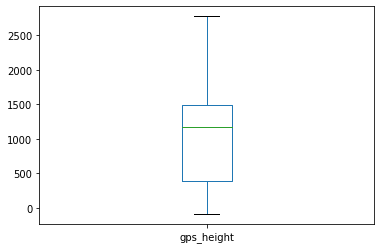

In [11]:
#gps_height
trainTestDF["gps_height"].replace(0, np.nan, inplace=True)
trainTestDF['gps_height'].plot(kind='box')
trainTestDF.groupby('basin')['gps_height'].agg('mean')

In [12]:
#2. impute mean
trainTestDF['gps_height'] = trainTestDF['gps_height'].fillna(trainTestDF.groupby('basin')['gps_height'].transform('mean'))
print('Zero values in gps_height: ' + format(sum(trainTestDF['gps_height']==0)))
print('Nan values in gps_height: ' + format(sum(trainTestDF['gps_height'].isna())))

Zero values in gps_height: 0
Nan values in gps_height: 0


### Construction year
Construction year will be assigned as the median year for each basin.

basin
Internal                   2002.0
Lake Nyasa                 2000.0
Lake Rukwa                 1989.0
Lake Tanganyika            1997.0
Lake Victoria              1998.0
Pangani                    2000.0
Rufiji                     2000.0
Ruvuma / Southern Coast    1996.0
Wami / Ruvu                2004.0
Name: construction_year, dtype: float64

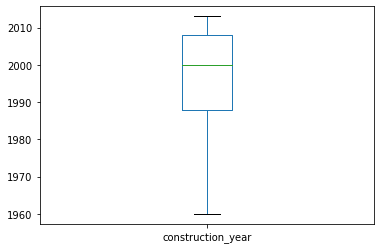

In [13]:
#construction_year
#1. replace zero with nan
trainTestDF["construction_year"].replace(0, np.nan, inplace=True)
trainTestDF['construction_year'].plot(kind='box')
trainTestDF.groupby('basin')['construction_year'].agg('median')

In [14]:
#2. impute median
trainTestDF['construction_year'] = trainTestDF['construction_year'].fillna(trainTestDF.groupby('basin')['construction_year'].transform('median'))
print('Zero values in construction_year: ' + format(sum(trainTestDF['population']==0)))
print('Nan values in construction_year: ' + format(sum(trainTestDF['construction_year'].isna())))

Zero values in construction_year: 0
Nan values in construction_year: 0


### 2.3.3 Removing outliers

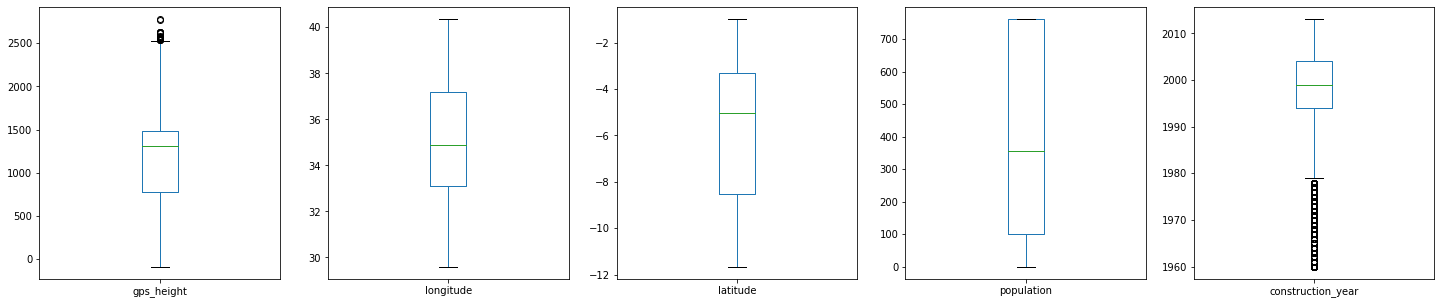

In [15]:
#outliers
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(25, 5))

trainTestDF['gps_height'].plot(kind='box',ax=axs[0])
trainTestDF['longitude'].plot(kind='box',ax=axs[1])
trainTestDF['latitude'].plot(kind='box',ax=axs[2])
trainTestDF['population'].plot(kind='box',ax=axs[3])
trainTestDF['construction_year'].plot(kind='box',ax=axs[4])
plt.show()

After imputing the median value per basin in the observations that didn't have a construction year, we can see that the distribution for this variable now presents outliers that are the years between 1960 and 1980. For this cases we will replace the value of the outlier with **q1 - 1.5 iqr**.

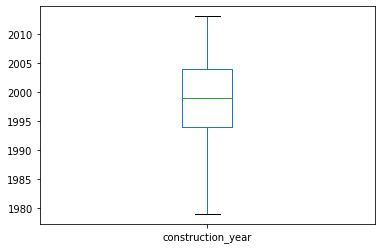

In [16]:
#remove outliers from construction_year
import warnings; warnings.simplefilter('ignore')
change_outliers(trainTestDF,'construction_year')
trainTestDF['construction_year'].plot(kind='box')

## Categorical variables

In [17]:
##setting categorical columns

categoricalColumnsList = ['id','funder','installer','wpt_name','basin','subvillage','region','region_code','district_code',\
                         'lga','ward','public_meeting','recorded_by','scheme_management','scheme_name','permit',\
                         'extraction_type_group','extraction_type_class','management','management_group','payment_type',\
                         'water_quality','quality_group','quantity_group','source','source_type','source_class',\
                         'waterpoint_type','waterpoint_type_group','extraction_type','payment','quantity','status_group','dataset']

for col in categoricalColumnsList:
    trainTestDF[col] = trainTestDF[col].astype('category')

categoricalColumnsDF = trainTestDF[categoricalColumnsList]

### 2.3.4 Null values
There are a lot of null values in some of the categorical features, however it is important to understand in which features we are observing this missing data.

In [18]:
#checking for null values in the categorical values

print('Null values: ' + format(categoricalColumnsDF.isnull().sum().sum()))
pd.set_option('display.max_columns', None)


Null values: 57558


In [19]:
categoricalColumnsDF.describe()

,id,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,extraction_type,payment,quantity,status_group,dataset
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,74250,74250,70095,74250,69404,38992,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,74250,2140,2410,45684,9,21425,21,27,20,125,2098,2,1,12,2868,2,13,7,12,5,7,8,6,5,10,7,3,7,6,18,7,5,3,2
top,74249,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,11,1,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,gravity,never pay,enough,0,train
freq,1,11299,21751,4440,12871,646,6599,6608,15299,3128,386,63749,74250,45917,858,48606,33263,33263,50624,65538,31712,63505,63505,41522,21216,21216,57286,35628,43239,33263,31712,41522,47109,59400


The features that have missing values are:

* Funder

* Installer

* Subvillage

* Public meeting

* Scheme management

* Permit

For imputing the missing values we will use the most common values (mode) considering some geographic factors as it follows:

* For funder, installer, public_meeting, scheme_management and scheme_name we will assign the most common value by basin.

* The subvillage will be deducted as the mode of each region and the permit will also use region to get the most common value.

In [20]:
#impute the mode in the categories with na values

trainTestDF['subvillage']=trainTestDF.groupby('region').subvillage.transform(lambda x: x.fillna(x.mode()[0]))

#funder and installer will be deducted from basin (0.65 cramer's v)
trainTestDF['funder']=trainTestDF.groupby('basin').funder.transform(lambda x: x.fillna(x.mode()[0]))
trainTestDF['installer']=trainTestDF.groupby('basin').installer.transform(lambda x: x.fillna(x.mode()[0]))

#public meeting will be deducted from installer (0.41 cramer's v)
trainTestDF['public_meeting']=trainTestDF.groupby('basin').public_meeting.transform(lambda x: x.fillna(x.mode()[0]))

#scheme_management will be deducted from basin
trainTestDF['scheme_management']= trainTestDF.groupby('basin').scheme_management.transform(lambda x: x.fillna(x.mode()[0]))

#scheme_name will be deducted from basin (0.9 cramer's v)
trainTestDF['scheme_name']=trainTestDF.groupby('basin').scheme_name.transform(lambda x: x.fillna(x.mode()[0]))

#permit will be deducted from subvillage (0.63 cramer's v)
trainTestDF['permit']=trainTestDF.groupby('region').permit.transform(lambda x: x.fillna(x.mode()[0]))

trainTestDF[categoricalColumnsList].describe()


,id,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,extraction_type,payment,quantity,status_group,dataset
count,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,74250,2140,2410,45684,9,21425,21,27,20,125,2098,2,1,12,2868,2,13,7,12,5,7,8,6,5,10,7,3,7,6,18,7,5,3,2
top,74249,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,11,1,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,None,True,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,gravity,never pay,enough,0,train
freq,1,12915,24593,4440,12871,646,6599,6608,15299,3128,386,67904,74250,50763,14755,52359,33263,33263,50624,65538,31712,63505,63505,41522,21216,21216,57286,35628,43239,33263,31712,41522,47109,59400


## 2.4 Feature engineering


### 2.4.1 Feature creation

From the numerical variables we will create a new feature that can be more informative than the construction year and it is "years of operation" for each pump at the time that the observation was recorded, while it was functional, non functional or functional needing repair.

In [21]:
# #feature creation for how long the pump has been operational
from datetime import datetime
trainTestDF['date_recorded']= trainTestDF['date_recorded'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trainTestDF['year_recorded'] = trainTestDF['date_recorded'].map(lambda x: x.year)
trainTestDF['operational_years'] = trainTestDF['year_recorded'] - trainTestDF['construction_year']

We have variables that have too many levels, as funder and installer for instance, which we consider that if we use in our model can lead to an overfitting problem, even if they are important. Since funder and installer have a very similar Cramer's V, they are giving almost the same information to the target variable and many times have the same information, however the values are written differently (with and without capital letters or with abbreviations). For this reason we will create a new feature that after defining if the string in funder and installer is almost the same, will have 1 if the funder and installer are the same company and 0 if they are different.

In order to check if the funder and installer are the same we will use the library *fuzzywuzzy* which with the function fuzz.ratio compares the two strings and using the Levenshtein's distance assigns a coefficient between 0 and 100 of how similar are the two strings. We defined a threshold of 50 for defining if the funder and installer are the same, but just written in a different way.


In [22]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

#changing all values to lowercase to reduce Levenshtein distance and then identify similar strings
trainTestDF['installer'] = trainTestDF['installer'].str.lower()
trainTestDF['funder'] = trainTestDF['funder'].str.lower()
trainTestDF['similarFundInst']  = trainTestDF.apply(lambda x: fuzz.ratio(x['installer'],x['funder']), axis=1)
trainTestDF['sameInstallerFunder'] = np.where(trainTestDF['similarFundInst']>50,1,0)
trainTestDF['sameInstallerFunder'] = trainTestDF['sameInstallerFunder'].astype('category')

### 2.4.2 Dimensionality reduction

High dimensionality can be problematic for any machine learning algorithm, even for the tree-based ones, increasing how complex is a problem. In this case we tried to find linear relationships between the numerical variables, in order to perform a Principal Component Analysis. As we know from the dataset that we were given, most of the features are categorical and are not suitable for PCA, but we want to see if it is worth it to do PCA with the continuous features.

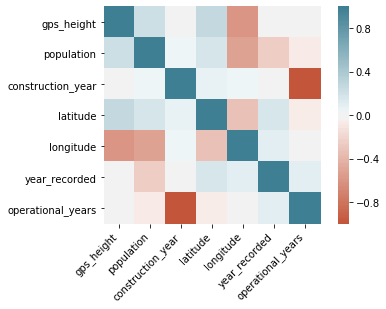

In [23]:
#computing Pearson's correlation among the numerical features
numericalColumnsList = ['gps_height','population','construction_year','latitude','longitude','year_recorded','operational_years']
numericalVariablesDF = trainTestDF[numericalColumnsList]
# numericalVariablesDF.set_index('id',inplace=True)

corr = numericalVariablesDF.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From this correlation matrix we can observe that there are not many linear relationships between the numerical variables. The most important linear relationships that we have are:

* population and gps_height: There is an inverse relationship between these features, but from the business point of view it doesn't represent a logical relationship. This may be one of those cases in which correlation doesn't mean causation.

* longitude and latitude: As they are location features representing the geographic coordinates where a pump is located around Tanzania, it makes sense that these features show this behavior.

* construction_year and operational_years: The feature operational_years was created using the year when the pump was created, therefore is normal that they are highly correlated but it doesn't mean that we can find more information here than we already have.

After observing this behavior, we performed a PCA to see if the accuracy of our model was better than when we were not using PCA and choosing the most important components, and we concluded that our cross validated score was better when we don't use PCA. This is not a surprise, given what we already mentioned above about the lack of linear relationships between the variables, therefore it won't be included in this document.

On the other hand, from the previous analysis and for the knowledge that we have gained from the data, we know that many of the categorical variables contain the same information, have too many levels and are not relevant. Consequently, the dimensionality reduction will be done considering those factors.



### Cramer's V as a measure of association between categorical features and target
Given that most of the features in this dataset are categorical, it is not possible to use a measure of relation as the Pearson's correlation coefficient (even if we dummify the categorical features) to understand their impact in the target variable, which is categorical as well. 

Therefore we will use the Cramer's V to understand the association between the categorical features and the target variable, to understand the importance of this variables as predictors of the status of a pump. This will be considered in the following sections for removing some features that might not be relevant.

In [24]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramersv_dataframe(dataframe,nameTarget):
    for col in dataframe:
        print('Cramer´s V for {}: '.format(col) + format(round(cramers_v(dataframe[col],dataframe[nameTarget]),3)))

cramersv_dataframe(categoricalColumnsDF,'status_group')


Cramer´s V for id: nan
Cramer´s V for funder: 0.259
Cramer´s V for installer: 0.26
Cramer´s V for wpt_name: 0.137
Cramer´s V for basin: 0.106
Cramer´s V for subvillage: 0.335
Cramer´s V for region: 0.171
Cramer´s V for region_code: 0.177
Cramer´s V for district_code: 0.1
Cramer´s V for lga: 0.265
Cramer´s V for ward: 0.371
Cramer´s V for public_meeting: 0.06
Cramer´s V for recorded_by: nan
Cramer´s V for scheme_management: 0.111
Cramer´s V for scheme_name: 0.441
Cramer´s V for permit: 0.029
Cramer´s V for extraction_type_group: 0.207
Cramer´s V for extraction_type_class: 0.202
Cramer´s V for management: 0.112
Cramer´s V for management_group: 0.043
Cramer´s V for payment_type: 0.154
Cramer´s V for water_quality: 0.117
Cramer´s V for quality_group: 0.112
Cramer´s V for quantity_group: 0.262
Cramer´s V for source: 0.127
Cramer´s V for source_type: 0.108
Cramer´s V for source_class: 0.063
Cramer´s V for waterpoint_type: 0.209
Cramer´s V for waterpoint_type_group: 0.189
Cramer´s V for extra

### Features with the same information
The categorical variables that have the same information will have a Cramer's V of nearly 1. In this cases we will only keep one of the variables.

In [25]:
extraction_type_classDF = trainTestDF[['extraction_type_class','extraction_type_group']]
cramersv_dataframe(extraction_type_classDF,'extraction_type_class')

Cramer´s V for extraction_type_class: 1.0
Cramer´s V for extraction_type_group: 1.0


In [26]:
water_qualityDF = trainTestDF[['water_quality','quality_group']]
cramersv_dataframe(water_qualityDF,'quality_group')

Cramer´s V for water_quality: 1.0
Cramer´s V for quality_group: 1.0


In [27]:
sourceDF = trainTestDF[['source','source_type']]
cramersv_dataframe(sourceDF,'source_type')

Cramer´s V for source: 1.0
Cramer´s V for source_type: 1.0


In [28]:
waterpointDF = trainTestDF[['waterpoint_type_group','waterpoint_type']]
cramersv_dataframe(waterpointDF,'waterpoint_type')

Cramer´s V for waterpoint_type_group: 1.0
Cramer´s V for waterpoint_type: 1.0


In [29]:
quantityDF = trainTestDF[['quantity','quantity_group']]
cramersv_dataframe(quantityDF,'quantity_group')

Cramer´s V for quantity: 1.0
Cramer´s V for quantity_group: 1.0


In [30]:
paymentDF = trainTestDF[['payment','payment_type']]
cramersv_dataframe(paymentDF,'payment_type')

Cramer´s V for payment: 1.0
Cramer´s V for payment_type: 1.0


In [31]:
schemeDF = trainTestDF[['scheme_name','scheme_management']]
cramersv_dataframe(schemeDF,'scheme_management')

Cramer´s V for scheme_name: 0.55
Cramer´s V for scheme_management: 1.0


In [32]:
# We have 6 features for a geographic location (additional to latitude and longitude). We'll keep only region
trainTestDF.drop(columns=['region_code','district_code','lga','ward','subvillage'],inplace=True)

In [33]:
#Drop variables that have the same information from Cramer's V
trainTestDF.drop(columns=['extraction_type_group','quality_group','source_type','waterpoint_type_group','quantity_group','payment'],axis=1,inplace=True)

### Features with too many levels
The features with around 2000 levels can be very problematic for any machine learning model, because it augments the complexity of the business problem that we are trying to solve and most probably will overfit. One of the main concerns when we were analyzing this problem was to increase the dimensions with variables that we consider are not relevant, so the following features will be discarded for this reason.

In [34]:
#analyzing count of levels for categorical variables
categoricalColumnsDF.agg(['count', 'size', 'nunique'])

,id,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,extraction_type,payment,quantity,status_group,dataset
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,74250,74250,70095,74250,69404,38992,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
size,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
nunique,74250,2140,2410,45684,9,21425,21,27,20,125,2098,2,1,12,2868,2,13,7,12,5,7,8,6,5,10,7,3,7,6,18,7,5,3,2


In [35]:
#we will reduce the number of levels for the scheme_name feature
trainTestDF= trainTestDF.apply(lambda x: x.mask(x.map(x.value_counts())<350, 'Other') if x.name=='scheme_name' else x)


### Non relevant features

In [36]:
#we'll drop the features that we've analyzed that are not relevant, have too many missing values, 
#too many levels, are intermediate computations or ar constants
trainTestDF.drop('amount_tsh',axis=1,inplace=True)
trainTestDF.drop('date_recorded',axis=1,inplace=True)
trainTestDF.drop('recorded_by',axis=1,inplace=True)
trainTestDF.drop('scheme_management',axis=1,inplace=True)
trainTestDF.drop('scheme_name',axis=1,inplace=True)
trainTestDF.drop('management_group',axis=1,inplace=True)
trainTestDF.drop('source_class',axis=1,inplace=True)
trainTestDF.drop('extraction_type_class',axis=1,inplace=True)
trainTestDF.drop(columns=['similarFundInst'],inplace=True)
trainTestDF.drop(columns=['funder','installer'],axis=1,inplace=True)
trainTestDF.drop('wpt_name',axis=1,inplace=True)
trainTestDF.drop('num_private',axis=1,inplace=True)

#set id
trainTestDF.set_index('id',inplace=True)

## 2.5 Handling imbalanced data
This is one of the most important yet simple transformations that we will perform in the dataset before creating our classifier. As it was mentioned at the beginning of this document, there is a clear imbalance of classes in the train set. Since we are using this data for training our model, we could see that the class that was having more issues for being correctly predicted was class 1 (functional needs repair). This class represents pumps that are going to work but that will need maintenance and this maintenance is highly relevant for avoiding that a pump will become non functional. From a Government point of view, represented in this case by the Ministry of Water in Tanzania and given that the functionality of water pumps have a strong social impact for people, avoiding that functional pumps become non functional is extremely important. 

With this premise, we analyzed the results that we were getting with the original dataset and we saw that some pumps that might need some maintenance were wrongly classified as functional, which might be dangerous because the pumps that belong to this class are not going to be closely monitored if they seem fine and functional. For this reason, we prefer to sacrifice accuracy in less than 0.3% for classes 0 and 2, but having better results predicting the minority class with more certainty, in order for the Ministry to act in a rapid manner.

For doing this, we used a simple technique for over-sampling the minority class, almost doubling its share in the target variable, using the real data that we already had and increasing the size of the train set as a consequence.

In [37]:
from sklearn.utils import resample
categorical_transformed_trainDF = trainTestDF[trainTestDF['dataset']=='train']
categorical_transformed_testDF = trainTestDF[trainTestDF['dataset']=='test']

# Separate majority and minority classes
df_majority = categorical_transformed_trainDF[categorical_transformed_trainDF.status_group!=1]
df_minority = categorical_transformed_trainDF[categorical_transformed_trainDF.status_group==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=8000,    
                                 random_state=123)
 
# Combine majority class with upsampled minority class
categorical_transformed_trainDF = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
categorical_transformed_trainDF.status_group.value_counts()


0    32259
2    22824
1     8000
Name: status_group, dtype: int64

## 2.6 One hot encoding for categorical variables


In [38]:
#one hot encoding for categorical variables
y_train_complete_up = categorical_transformed_trainDF['status_group']
y_test_complete = categorical_transformed_testDF['status_group']
targetTrain = categorical_transformed_trainDF['status_group']

drops = ['status_group','dataset']
categorical_ohe_train = categorical_transformed_trainDF.loc[:,~categorical_transformed_trainDF.columns.isin(drops)]
categorical_ohe_test = categorical_transformed_testDF.loc[:,~categorical_transformed_testDF.columns.isin(drops)]

X_train_complete_up = pd.get_dummies(categorical_ohe_train) 
X_test_complete = pd.get_dummies(categorical_ohe_test)
X_train_complete_up.head(1)


,gps_height,longitude,latitude,population,construction_year,year_recorded,operational_years,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,public_meeting_False,public_meeting_True,permit_False,permit_True,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,sameInstallerFunder_0,sameInstallerFunder_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,1390.0,34.938093,-9.856322,109.0,1999.0,2011,12.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


# 3. Classifier
As it was briefly mentioned above, we are going to work with tree-based algorithms in order to solve this multi classification problem. We started with 42 features that were given in the dataset from Tanzania's Ministry of Water, but throughout this whole work we've discovered that there might be more information in the original features if we perform some feature engineering. Additionally, we decided to work with one hot encoding for dealing with the categorical features that are relevant for our classifier, which increased significantly the dimensions that we are going to work with. As a consequence, we consider that tree-based algorithms are a good approach for this classification problem, given that these models can handle a large number of features and can handle numerical variables with the original values, therefore we won't perform any standardization of the continuous features in this case.

In [39]:
#some functions
import itertools
from collections import defaultdict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix_model(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


After trying different tree-based approaches (XG Boost and Random Forest) with different parameters, we saw that Random Forest was the best algorithm for this business case. **Furthermore, there is an important thing to consider given the over-sampling that we did that will impact how we interpret our accuracy score.**

For predicting the test set we will use the model that we are going to train with the over-sampling for the minority class. However, we won't consider the accuracy of this model as the real one, because since we are increasing the size of the minority class and more observations of this class are being correctly classified, it's obvious that it will increase accuracy for this effect. Consequently, we are also going to compute the accuracy score for the same model but without over-sampling in the data set, which will give us a more realistic accuracy score for our model.

## 3.1 Random Forest with over-sampling for status_group = 1

0.8344561499168041

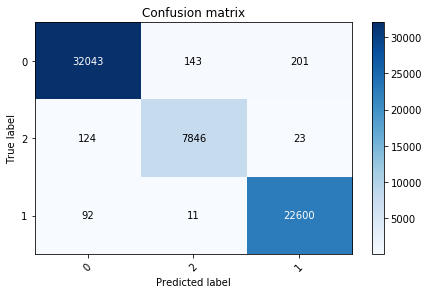

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

water_rf_up = RandomForestClassifier(bootstrap=True,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=6, oob_score=False, random_state=1337,
            verbose=0, warm_start=False)


water_rf_up.fit(X_train_complete_up,y_train_complete_up)
predictionsRFCV_train = water_rf_up.predict(X_train_complete_up)

predictionsRFCV_train = predictionsRFCV_train.round()
predictionsRFCV_train_DF = pd.DataFrame(predictionsRFCV_train, columns=['prediction'])
conf_mat_dt_RFCV_train = confusion_matrix(predictionsRFCV_train_DF, y_train_complete_up)

plot_confusion_matrix_model(conf_mat_dt_RFCV_train,predictionsRFCV_train_DF['prediction'].unique(),cmap=plt.cm.Blues)

scores_up = cross_val_score(water_rf_up, X_train_complete_up, y_train_complete_up, cv = 5, scoring='accuracy')
scores_up.mean()

## 3.2 Random Forest without over-sampling

0.8047474747474748

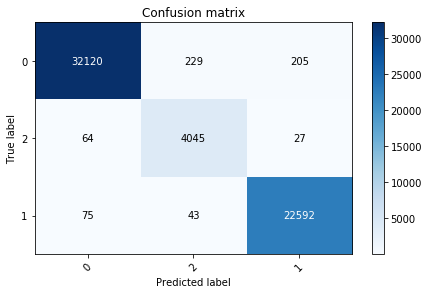

In [41]:
categorical_transformed_trainDF = trainTestDF[trainTestDF['dataset']=='train']
categorical_transformed_testDF = trainTestDF[trainTestDF['dataset']=='test']
y_train_complete = categorical_transformed_trainDF['status_group']
# y_test_complete = categorical_transformed_testDF['status_group']
# targetTrain = categorical_transformed_trainDF['status_group']
drops = ['status_group','dataset']
categorical_ohe_train = categorical_transformed_trainDF.loc[:,~categorical_transformed_trainDF.columns.isin(drops)]
categorical_ohe_test = categorical_transformed_testDF.loc[:,~categorical_transformed_testDF.columns.isin(drops)]
X_train_complete = pd.get_dummies(categorical_ohe_train) 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

water_rf_up.fit(X_train_complete,y_train_complete)
predictionsRFCV_train = water_rf_up.predict(X_train_complete)

predictionsRFCV_train = predictionsRFCV_train.round()
predictionsRFCV_train_DF = pd.DataFrame(predictionsRFCV_train, columns=['prediction'])
conf_mat_dt_RFCV_train = confusion_matrix(predictionsRFCV_train_DF, y_train_complete)

plot_confusion_matrix_model(conf_mat_dt_RFCV_train,predictionsRFCV_train_DF['prediction'].unique(),cmap=plt.cm.Blues)

scores = cross_val_score(water_rf_up, X_train_complete, y_train_complete, cv = 5, scoring='accuracy')
scores.mean()

After using our final model for predicting the dataset with the original size we can observe that the actual cross validated accuracy score for this model would be around 80.47%, which reflects the reality correctly. Something that we must highlight, is that when we use the over-sampled dataset we obtain much better results predicting the minority class in absolute values (272 wrongly predicted without over-sampling vs 154 wrongly predicted using over-sampling).

On the other hand, it is important to say that using Python's Randomized Search we defined the parameters that were used in our final model. Given that our final dataset is quite large and computation time is very high we will not include this part in the code, but the number of trees, criterion and number of features were obtained using this function, ensuring that regularization will help us avoid overfitting.

## 3.3 Selection of most relevant features for the algorithm

Finally, for avoiding overfitting, we will also choose the most important features from our one hot encoded data set, which will discard features that are not important enough using a determined threshold, which will reshape the train and test set using only relevant features.

In [42]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

feat_labels = list(X_train_complete_up.columns.values)
for feature in zip(feat_labels, water_rf_up.feature_importances_):
    print(feature)
    
sfm = SelectFromModel(water_rf_up, threshold=0.003)
sfm.fit(X_train_complete_up, y_train_complete_up)

('gps_height', 0.07100941360838156)
('longitude', 0.14624707781351853)
('latitude', 0.14264045225184493)
('population', 0.04788602606880278)
('construction_year', 0.04430469435042321)
('year_recorded', 0.009554466069700665)
('operational_years', 0.04534688752498776)
('basin_Internal', 0.004285710489122621)
('basin_Lake Nyasa', 0.0032089383205567063)
('basin_Lake Rukwa', 0.0020943985580114885)
('basin_Lake Tanganyika', 0.0032936940025016714)
('basin_Lake Victoria', 0.0037706458627609343)
('basin_Pangani', 0.0037299448116474413)
('basin_Rufiji', 0.0036328134063714507)
('basin_Ruvuma / Southern Coast', 0.00284826652692496)
('basin_Wami / Ruvu', 0.003228599101364089)
('region_Arusha', 0.0025978388848860233)
('region_Dar es Salaam', 0.0004680827771391414)
('region_Dodoma', 0.0020611986645768777)
('region_Iringa', 0.0060830332343725976)
('region_Kagera', 0.0018286643908461092)
('region_Kigoma', 0.0029968215022109675)
('region_Kilimanjaro', 0.0027416637137399114)
('region_Lindi', 0.0013836272

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='entropy',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=3,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=140, n_jobs=6,
                                                 oob_score=False,

In [43]:
   
X_important_train = sfm.transform(X_train_complete_up)
X_important_test = sfm.transform(X_test_complete)

water_rf_important = RandomForestClassifier(bootstrap=True,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=6, oob_score=False, random_state=1337,
            verbose=0, warm_start=False)

water_rf_important.fit(X_important_train, y_train_complete_up)
scoresImportant = cross_val_score(water_rf_important, X_important_train, y_train_complete_up, cv = 5, scoring='accuracy')
scoresImportant.mean()

0.8348365978022123

## 3.4 Final score in Data Driven

We tried different models that were submitted to the Data Driven Platform

# 4. Writing csv with predictions

In [44]:
import csv
#changes when the predictions are mode with the feature importance new dataset
finalPredictions = pd.DataFrame(water_rf_important.predict(X_important_test))
finalPredictions.index = X_test_complete.index
finalPredictions.columns = ['status_group']

predictions = finalPredictions.copy()
predictions['status_group'].replace(2,'non functional',inplace=True)
predictions['status_group'].replace(1,'functional needs repair',inplace=True)
predictions['status_group'].replace(0,'functional',inplace=True)
predictions.reset_index(inplace=True)
predictions.to_csv('C:/Users/Asus/Downloads/finalPred.csv',index=False)
